## Домашнее задание, вычисление аддитивного аттеншна

готовый ноутбук слать на o.shlyazhko@corp.mail.ru с заголовком "Домашнее задание по лекции seq2seq (Ваши Фамилия и Имя)"

In [1]:
from tqdm import tqdm_notebook
from io import open
import unicodedata
import string
import re
import random
import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

if torch.cuda.is_available():
    print('CUDA')
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

CUDA


In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
!tail data/rus_eng_small.txt

она экономически независима от своих родителей .	she is economically independent of her parents .
она направила наши усилия в нужном направлении .	she steered our efforts in the right direction .
на этом заводе производят телевизоры .	they are manufacturing tv sets in this factory .
она всегда жалуется из за моей маленькой зарплаты .	she is always complaining about my small salary .
они стоят там и едят чипсы .	they are standing there and eating potato chips .
мне не удаётся скомпилировать эту программу .	i m having some problems compiling this software .
она улыбнулась в ответ на его нежный взгляд .	she smiled in response to his affectionate glance .
она проводит каждое воскресенье со своей бабушкой .	she spends time with her grandmother every sunday .
каждую субботу после обеда она играет в теннис .	she spends every saturday afternoon playing tennis .
после аварии она перестала бывать на людях .	she stopped appearing in public after her accident .


In [4]:
def readLangs():
    print("Loading dataset...")
    pairs = []
    # Read the file and split into lines
    with open('data/rus_eng_small.txt') as f:
        for l in tqdm_notebook(f):
            pair = [s for s in l.rstrip('\n').split('\t')]
            pairs.append(pair)

    return Lang('rus'), Lang('eng'), pairs

In [5]:
def prepareData():
    input_lang, output_lang, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData()
MAX_LENGTH = 10
print(random.choice(pairs))

Loading dataset...



Read 19288 sentence pairs
Counting words...
Counted words:
rus 8960
eng 3914
['я смертельно устала .', 'i m dead tired .']


In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, nlayers, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, nlayers)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.nlayers, 1, self.hidden_size, device=device), \
               torch.zeros(self.nlayers, 1, self.hidden_size, device=device)

## Заполните метод вычисления аддитивного аттеншна в ячейке ниже.

готовый ноутбук слать на o.shlyazhko@corp.mail.ru с заголовком "Домашнее задание по лекции seq2seq (Ваши Фамилия и Имя)"

In [139]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, nlayers, output_size, dropout_p=0.4, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, nlayers)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
        self.dropout = nn.Dropout(self.dropout_p)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_get_weights = nn.Sequential(
            nn.Linear(self.hidden_size * 2, self.hidden_size), # W_a
            nn.Tanh(), # activation
            nn.Linear(self.hidden_size, 1) # v_a
        )
        
        self.softmax = nn.LogSoftmax(dim=1)
        

    def forward(self, x, hidden, encoder_outputs):
        """
        :param x: [T2,B] - входной тензор с предыдущими словами размерностью timestep на batch
        :param hidden [1, B, H] - состояние рнн слоя
        :param encoder_outputs [T1,B,H] - выходы всех шагов энкодера
        :return output: [T2,B,H], hidden - H=hidden_size, возвращается только последний hidden state
        """
        embedded = self.embedding(x) # [T2, B, H]
        encoder_outputs = encoder_outputs.transpose(0, 1) # [B, T1, H]
        outputs = []

        for i in range(x.size(0)):
            h_t = hidden[0].transpose(0, 1).transpose(1, -1) # [B, H, 1]

            context, attn_weights = self.attention(encoder_outputs, h_t)

            e = embedded[i].unsqueeze(0)
            output = torch.cat((e, context), dim=-1) # [[B, 1, H];[B, 1, H]] -> [B, 1, H*2]
            # [B, 1, H*2] * [H*2, H] = [B, 1, H] -transpose-> [1, B, H]
            output = self.attn_combine(output).transpose(0,1) 
            output = F.relu(output)
            output, hidden = self.rnn(output, hidden)

            logits = self.out(output)
            output = F.log_softmax(logits, dim=-1)
            outputs.append(output)

        output = torch.cat(outputs, dim=0)
        return output, hidden, attn_weights
    
    def attention(self, encoder_outputs, h):
        B, T, H = encoder_outputs.size()
        attn_input = torch.cat((
            encoder_outputs,
            h.permute(0, 2, 1).repeat(1, T, 1) # [B,H,1] -> [B,T,H]
        ), dim=-1) # [B,T,2*H]
        attn_weights = F.softmax(self.attn_get_weights(attn_input), dim=-2) # [B,T,1]

        # Для каждой позиции выхода веса содержат значения для всех позиций входа T1
        # В таком случае взвешенная сумма может быть посчитана за одно матричное умножение
        # [B,1,T1]x[B,T1,H] -> B [1,T1]x[T1,H] = [B, 1, H]
        context = torch.bmm(attn_weights.transpose(1,-1), encoder_outputs)
        # на выходе имеем вектор контекста размерностью H для каждой позиции выхода T2
        return context, attn_weights

    def initHidden(self):
        """Инициализируем состояние LSTM нулями"""
        return torch.zeros(self.nlayers, 1, self.hidden_size, device=device), \
               torch.zeros(self.nlayers, 1, self.hidden_size, device=device)

In [89]:
def train(input_tensor, target_tensor, 
          encoder, decoder, 
          optimizer,  criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    if teacher_forcing_ratio == 1.: # use fast parallel mode
        decoder_input = torch.cat([decoder_input, target_tensor[:-1]], dim=0)
        decoder_outputs, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_outputs = decoder_outputs.squeeze()
        loss += criterion(decoder_outputs, target_tensor.squeeze())
        loss_value = loss.item()
    else:
        for di in range(target_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            loss += criterion(decoder_output, target_tensor[di])
            if use_teacher_forcing:
                decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            else:
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
        loss_value =  loss.item() / target_length

    loss.backward()

    optimizer.step()

    return loss_value

In [90]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [91]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [92]:
def run_training(encoder, decoder, n_iters, print_every=1000, plot_every=100):
    print('Train')
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            dt = time_since(start, iter / n_iters)
            print('%s (%d %d%%) %.4f' % (dt, iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [93]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden # STATE TRANSFER
    
        decoded_words = []
        decoder_attentions = []
        for di in range(max_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions.append(decoder_attention)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            if topi.item() == EOS_token:
                break
            word = output_lang.index2word[topi.item()]
            decoded_words.append(word)

        return decoded_words, decoder_attentions

In [94]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [144]:
n_iters=40000
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in tqdm_notebook(range(n_iters), desc='prepare set')]

In [145]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, 1, hidden_size).to(device)
decoder = AttnDecoder(hidden_size, 1, output_lang.n_words, dropout_p=0.1).to(device)

In [146]:
teacher_forcing_ratio = 1.
learning_rate=0.001
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)
criterion = nn.NLLLoss()

### Не забудьте запустить тренировку в ячейке ниже, а затем и evaluation

Train
0m 21s (- 13m 48s) (1000 2%) 3.2369
0m 54s (- 17m 15s) (2000 5%) 2.6606
1m 16s (- 15m 48s) (3000 7%) 2.5212
1m 40s (- 15m 5s) (4000 10%) 2.3580
2m 10s (- 15m 14s) (5000 12%) 2.2494
2m 33s (- 14m 29s) (6000 15%) 2.2277
2m 55s (- 13m 45s) (7000 17%) 2.1145
3m 26s (- 13m 44s) (8000 20%) 2.0667
3m 42s (- 12m 47s) (9000 22%) 1.9903
4m 3s (- 12m 9s) (10000 25%) 1.9910
4m 33s (- 12m 1s) (11000 27%) 1.9148
5m 4s (- 11m 50s) (12000 30%) 1.8648
5m 37s (- 11m 41s) (13000 32%) 1.8333
6m 2s (- 11m 12s) (14000 35%) 1.7319
6m 25s (- 10m 42s) (15000 37%) 1.7862
6m 48s (- 10m 12s) (16000 40%) 1.7723
7m 15s (- 9m 48s) (17000 42%) 1.7517
7m 43s (- 9m 26s) (18000 45%) 1.7130
8m 10s (- 9m 2s) (19000 47%) 1.6218
8m 42s (- 8m 42s) (20000 50%) 1.6335
9m 7s (- 8m 15s) (21000 52%) 1.5310
9m 30s (- 7m 46s) (22000 55%) 1.5361
9m 46s (- 7m 13s) (23000 57%) 1.5214
10m 3s (- 6m 42s) (24000 60%) 1.5320
10m 19s (- 6m 11s) (25000 62%) 1.5316
10m 35s (- 5m 42s) (26000 65%) 1.5816
10m 51s (- 5m 13s) (27000 67%) 1.4

<Figure size 432x288 with 0 Axes>

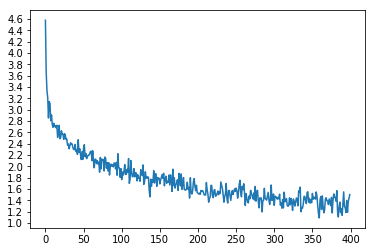

In [147]:
run_training(encoder, decoder, n_iters)

Train
0m 54s (- 17m 15s) (2000 5%) 1.2260
1m 47s (- 16m 10s) (4000 10%) 1.2260
2m 40s (- 15m 8s) (6000 15%) 1.1660
3m 33s (- 14m 14s) (8000 20%) 1.1644
4m 26s (- 13m 18s) (10000 25%) 1.1390
5m 18s (- 12m 23s) (12000 30%) 1.1199
6m 11s (- 11m 30s) (14000 35%) 1.0531
7m 3s (- 10m 35s) (16000 40%) 1.0818
7m 56s (- 9m 42s) (18000 45%) 1.0554
8m 49s (- 8m 49s) (20000 50%) 1.0355
9m 37s (- 7m 52s) (22000 55%) 0.9539
10m 15s (- 6m 50s) (24000 60%) 0.9736
10m 57s (- 5m 54s) (26000 65%) 1.0170
11m 33s (- 4m 57s) (28000 70%) 0.9607
12m 6s (- 4m 2s) (30000 75%) 0.9397
12m 38s (- 3m 9s) (32000 80%) 0.9087
13m 12s (- 2m 19s) (34000 85%) 0.9184
13m 50s (- 1m 32s) (36000 90%) 0.9332
14m 28s (- 0m 45s) (38000 95%) 0.9191
15m 5s (- 0m 0s) (40000 100%) 0.9031


<Figure size 432x288 with 0 Axes>

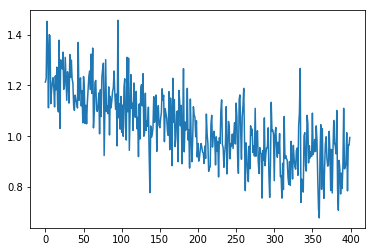

In [150]:
# и ещё разок, как в лекции :) надо было выставить сразу n_iters=80000, но я забыл, а учится оно долго
run_training(encoder, decoder, n_iters, print_every=2000)

In [154]:
evaluate_randomly(encoder, decoder, n=100)

> мы хотим спать .
= we re sleepy .
< we re sleepy .

> со мной обращаются как с преступником .
= i m being treated like a criminal .
< i m just like your be .

> я рада, что ты пришёл .
= i m glad that you came .
< i m glad you came .

> боюсь, положение очень серьёзное .
= i m afraid the situation is very serious .
< i m afraid i don of food .

> он человек, сделавший себя сам .
= he is a self made man .
< he is a stranger to a student .

> мне это опротивело .
= i m sick of it .
< i m sick of this .

> я иду в почтовое отделение .
= i am going to the post office .
< i m going to have a baby .

> я не ваш друг .
= i m no friend of yours .
< i m not your friend .

> мы все тобой очень гордимся .
= we re all very proud of you .
< we re all very proud of you .

> я смущен .
= i m confused .
< i m a canadian .

> вы симпатичная .
= you re cute .
< you re an angel .

> она всегда весёлая .
= she is always cheerful .
< she is always complaining .

> я безжалостный .
= i m ruthless .
< i m 

input = я очень осторожна .
output = i m very careful .


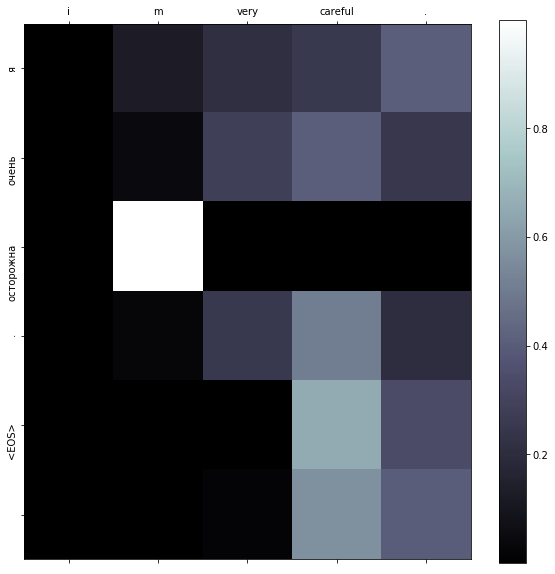

input = они всё ещё живут со своими родителями .
output = they re still looking forward to still coming .


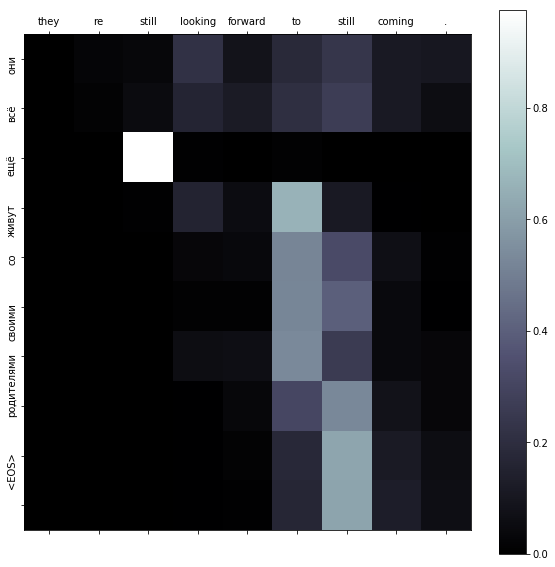

In [155]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_yticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    attentions = torch.cat(attentions).squeeze().cpu()
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("я очень осторожна .")
evaluateAndShowAttention("они всё ещё живут со своими родителями .")